# Exploratory Spatio-Temporal Data Analysis
# Part 1 - Data Inspection and Descriptive Statistics - Summary Statistics

In [1]:
import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

import folium
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [2]:
import xarray as xr 

ds = xr.open_dataset('/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/01_raw/ERA5_monthly_averaged_data_on_single_levels.nc')
# ds = xr.open_dataset('/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/02_intermediate/preprocessed_data.nc')

In [3]:
ds

<xarray.Dataset> Size: 51GB
Dimensions:    (date: 561, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * date       (date) int64 4kB 19780101 19780201 19780301 ... 20240801 20240901
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver     (date) <U4 9kB ...
Data variables: (12/22)
    u10        (date, latitude, longitude) float32 2GB ...
    v10        (date, latitude, longitude) float32 2GB ...
    t2m        (date, latitude, longitude) float32 2GB ...
    sst        (date, latitude, longitude) float32 2GB ...
    sp         (date, latitude, longitude) float32 2GB ...
    tp         (date, latitude, longitude) float32 2GB ...
    ...         ...
    slt        (date, latitude, longitude) float32 2GB ...
    cvh        (date, latitude, longitude) float32 2GB ...
    lai_hv     (date, latitude, longitude) float32 2GB ...
    tvh        (date, latitude, longitude) float32 2GB ...
    z          (date, latitude, longitude) float32 2GB ...
    lsm        (date, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-01T13:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
# INTO 3.data_preprocessing.ipynb 
import pandas as pd

# 1. Convert 'date' coordinate to datetime
ds['date'] = pd.to_datetime(ds['date'].astype(str), format='%Y%m%d')

In [5]:
ds

<xarray.Dataset> Size: 51GB
Dimensions:    (date: 561, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * date       (date) datetime64[ns] 4kB 1978-01-01 1978-02-01 ... 2024-09-01
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver     (date) <U4 9kB ...
Data variables: (12/22)
    u10        (date, latitude, longitude) float32 2GB ...
    v10        (date, latitude, longitude) float32 2GB ...
    t2m        (date, latitude, longitude) float32 2GB ...
    sst        (date, latitude, longitude) float32 2GB ...
    sp         (date, latitude, longitude) float32 2GB ...
    tp         (date, latitude, longitude) float32 2GB ...
    ...         ...
    slt        (date, latitude, longitude) float32 2GB ...
    cvh        (date, latitude, longitude) float32 2GB ...
    lai_hv     (date, latitude, longitude) float32 2GB ...
    tvh        (date, latitude, longitude) float32 2GB ...
    z          (date, latitude, longitude) float32 2GB ...
    lsm        (date, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-01T13:02 GRIB to CDM+CF via cfgrib-0.9.1...

## Data Inspection

### Area of intrest

In [20]:
import xarray as xr
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from typing import Optional

def visualize_variable_on_map(
    dataset: xr.Dataset,
    variable: str,
    time_dim: str = 'date',
    lat_dim: str = 'latitude',
    lon_dim: str = 'longitude',
    plot_type: str = 'scatter_geo',
    downsample_factor: Optional[int] = 1,
    projection: str = 'natural earth',
    color_scale: str = 'Viridis',
    title: Optional[str] = None,
    animation_frame: Optional[str] = None,
    hover_precision: int = 2,
    custom_colorbar_title: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    **kwargs
) -> go.Figure:
    """
    Universal function to visualize any variable from an xarray Dataset on a map with optional animation using Plotly.
    
    Parameters:
    - dataset (xr.Dataset): The xarray Dataset containing the data.
    - variable (str): The name of the variable to visualize.
    - time_dim (str): Name of the time dimension.
    - lat_dim (str): Name of the latitude dimension.
    - lon_dim (str): Name of the longitude dimension.
    - plot_type (str): Type of plot. Options include 'scatter_geo' and 'imshow'.
    - downsample_factor (int, optional): Factor by which to downsample spatial data.
    - projection (str): Map projection style for Plotly.
    - color_scale (str or list): Color scale for the plot.
    - title (str, optional): Title of the plot. Uses `GRIB_name` if available.
    - animation_frame (str, optional): Dimension to animate over.
    - hover_precision (int): Decimal precision for hover data.
    - custom_colorbar_title (str, optional): Custom title for the color bar. Uses `GRIB_units` if available.
    - start_date (str, optional): Start date for the data in ISO format (YYYY-MM-DD).
    - end_date (str, optional): End date for the data in ISO format (YYYY-MM-DD).
    - **kwargs: Additional keyword arguments passed to the Plotly plotting functions.
    
    Returns:
    - fig (plotly.graph_objs._figure.Figure): The Plotly figure object.
    """
    
    # Extract GRIB metadata for title and colorbar
    grib_name = dataset[variable].attrs.get("GRIB_name", variable)
    grib_units = dataset[variable].attrs.get("GRIB_units", "")
    
    # Use GRIB_name as title if not provided
    if not title:
        title = f"{grib_name}"
        if start_date or end_date:
            title += f" ({start_date or ''} to {end_date or ''})"
    
    # Set colorbar title
    colorbar_title = custom_colorbar_title if custom_colorbar_title else grib_units

    # Extract the DataArray
    da = dataset[variable]

    # Check if variable dimensions are correct
    for dim in [time_dim, lat_dim, lon_dim]:
        if dim not in da.dims:
            raise ValueError(f"Dimension '{dim}' not found in variable '{variable}'.")

    # Filter by date range if specified
    if start_date or end_date:
        if start_date:
            da = da.sel({time_dim: da[time_dim] >= pd.to_datetime(start_date)})
        if end_date:
            da = da.sel({time_dim: da[time_dim] <= pd.to_datetime(end_date)})

    # Downsample if required
    if downsample_factor > 1:
        da = da.coarsen({lat_dim: downsample_factor, lon_dim: downsample_factor}, boundary='trim').mean()

    # Calculate the global min and max for the color scale
    color_min = da.min().item()
    color_max = da.max().item()

    # Plotting
    if plot_type == 'scatter_geo':
        df = da.to_dataframe().reset_index().dropna(subset=[variable])

        fig = px.scatter_geo(
            df,
            lat=lat_dim,
            lon=lon_dim,
            color=variable,
            animation_frame=animation_frame,
            projection=projection,
            color_continuous_scale=color_scale,
            title=title,
            labels={variable: grib_name},
            hover_data={variable: f":.{hover_precision}f"},
            range_color=(color_min, color_max),  # Set constant color range
            **kwargs
        )

        fig.update_layout(
            coloraxis_colorbar=dict(
                title=colorbar_title,
                ticks="outside"
            )
        )
    
    elif plot_type == 'imshow':
        z = da.mean(dim=time_dim).values  # Aggregate over time dimension for a static plot
        if da[lat_dim][0] > da[lat_dim][-1]:
            z = z[::-1, :]
        
        fig = px.imshow(
            z,
            labels=dict(x=lon_dim, y=lat_dim, color=grib_name),
            x=da[lon_dim].values,
            y=da[lat_dim].values,
            color_continuous_scale=color_scale,
            title=title,
            range_color=(color_min, color_max),  # Set constant color range
            **kwargs
        )
        
        fig.update_layout(
            coloraxis_colorbar=dict(
                title=colorbar_title,
                ticks="outside"
            )
        )
    else:
        raise ValueError(f"Plot type '{plot_type}' is not supported.")
    
    return fig


Target variable: swvl3

In [8]:
# variable = 'u10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=15,
#     color_scale = 'Bluered'
# )
# fig.show()

In [15]:
# variable = 'v10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'Bluered'
# )
# fig.show()

In [94]:
# variable = 't2m'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'Thermal'
# )
# fig.show()

In [95]:
# variable = 'sst'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'Plasma'
# )
# fig.show()

In [96]:
# variable = 'sp'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'Plasma'
# )
# fig.show()

In [97]:
# variable = 'tp'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'Blues'
# )
# fig.show()

In [98]:
# variable = 'ssr'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'YlOrBr'
# )
# fig.show()

In [ ]:
# variable = 'ssrd'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'YlOrBr'
# )
# fig.show()

In [99]:
# variable = 'tcc'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'BuPu'
# )
# fig.show()

In [100]:
# variable = 'cl'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'Blues'
# )
# fig.show()

In [101]:
# variable = 'e'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'YlGnBu'
# )
# fig.show()

In [10]:
# variable = 'pev'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'YlGnBu'
# )
# fig.show()

In [30]:
# variable = 'ro'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'dense'
# )
# fig.show()

In [ ]:
# variable = 'asn'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'ice'
# )
# fig.show()

In [32]:
# variable = 'rsn'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'ice'
# )
# fig.show()

In [35]:
# variable = 'sd'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'ice'
# )
# fig.show()

In [129]:
# variable = 'slt'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'Rainbow'
# )
# fig.show()

In [105]:
# variable = 'cvh'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'YlGn'
# )
# fig.show()

In [106]:
# variable = 'lai_hv'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'tempo'
# )
# fig.show()

In [109]:
# variable = 'tvh'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'Rainbow'
# )
# fig.show()

In [111]:
# variable = 'z'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'RdBu_r'
# )
# fig.show()

In [112]:
# variable = 'lsm'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'Purpor'
# )
# fig.show()

### Missing values

In [12]:
import xarray as xr

def check_missing_percentage(dataset: xr.Dataset) -> dict:
    """
    Calculate the percentage of missing values for each variable in the xarray.Dataset.

    Args:
        dataset (xr.Dataset): The input dataset.

    Returns:
        dict: A dictionary with variable names as keys and their respective missing percentage as values.
    """
    missing_percentages = {}
    for var in dataset.data_vars:
        data = dataset[var]
        # Calculate the number of missing values and total elements
        missing_count = data.isnull().sum().item()
        total_count = data.size
        # Calculate the missing percentage
        missing_percentage = (missing_count / total_count) * 100
        missing_percentages[var] = missing_percentage
    
    return missing_percentages


In [15]:
# # Example usage
# missing_perc = check_missing_percentage(ds)

In [16]:
# missing_perc

{'u10': 0.0,
 'v10': 0.0,
 't2m': 0.0,
 'sst': 33.8915857605178,
 'sp': 0.0,
 'tp': 0.0,
 'ssr': 0.0,
 'ssrd': 0.0,
 'tcc': 0.0,
 'cl': 0.0,
 'e': 0.0,
 'pev': 0.0,
 'ro': 0.0,
 'asn': 0.0,
 'rsn': 0.0,
 'sd': 0.0,
 'slt': 0.0,
 'cvh': 0.0,
 'lai_hv': 0.0,
 'tvh': 0.0,
 'z': 0.0,
 'lsm': 0.0}

In [18]:
# INTO 3.data_preprocessing.ipynb 

import xarray as xr
from typing import List, Union

def fillna_in_variables(
    ds: xr.Dataset,
    variables: List[str],
    fill_value: Union[int, float]
) -> xr.Dataset:
    """
    Fills NaN values in specified variables of an xarray.Dataset with a provided value.

    Args:
        ds (xr.Dataset): The input dataset containing the data variables.
        variables (List[str]): A list of variable names in the dataset for which to fill NaN values.
        fill_value (Union[int, float]): The value to fill NaN values with (e.g., 0).

    Returns:
        xr.Dataset: A new dataset with NaN values filled in the specified variables.
    
    Raises:
        ValueError: If a variable in `variables` does not exist in the dataset.
    
    Example:
        filled_ds = fillna_in_variables(ds, ["t2m", "swvl1"], fill_value=0)
    """
    # Check if each variable exists in the dataset
    for var in variables:
        if var not in ds:
            raise ValueError(f"Variable '{var}' not found in the dataset.")
    
    # Fill NaN values for the specified variables
    filled_ds = ds.copy()
    for var in variables:
        filled_ds[var] = filled_ds[var].fillna(fill_value)
    
    return filled_ds


In [19]:
ds = fillna_in_variables(ds, ["sst"], fill_value=0)

In [20]:
# # Example usage
# missing_perc_after_filling = check_missing_percentage(ds)

In [21]:
# missing_perc_after_filling

### Distributions

In [39]:
import xarray as xr
import matplotlib.pyplot as plt

def plot_variable_distributions(ds: xr.Dataset) -> None:
    """
    Plot the distribution of each variable in the xarray Dataset.
    
    Args:
        ds (xr.Dataset): The xarray dataset containing variables to visualize.
    """
    # Iterate over each variable in the dataset
    for var in ds.data_vars:
        data = ds[var].values.flatten()  # Flatten the data for distribution plot
        
        # Remove NaN values to avoid plotting issues
        data = data[~np.isnan(data)]
        
        plt.figure(figsize=(10, 5))
        plt.hist(data, bins=50, alpha=0.7, color='violet')
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

# Usage
# plot_variable_distributions(ds)

## Descriptive statistics

### Summmary statistics

In [23]:
ds

<xarray.Dataset> Size: 51GB
Dimensions:    (date: 561, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * date       (date) datetime64[ns] 4kB 1978-01-01 1978-02-01 ... 2024-09-01
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver     (date) <U4 9kB ...
Data variables: (12/22)
    u10        (date, latitude, longitude) float32 2GB -0.118 -0.118 ... 4.475
    v10        (date, latitude, longitude) float32 2GB -0.03694 ... 0.2595
    t2m        (date, latitude, longitude) float32 2GB 242.7 242.7 ... 222.4
    sst        (date, latitude, longitude) float32 2GB 271.5 271.5 ... 0.0 0.0
    sp         (date, latitude, longitude) float32 2GB 1.015e+05 ... 6.782e+04
    tp         (date, latitude, longitude) float32 2GB 0.0001583 ... 0.0001621
    ...         ...
    slt        (date, latitude, longitude) float32 2GB 0.0 0.0 0.0 ... 1.0 1.0
    cvh        (date, latitude, longitude) float32 2GB 0.0 0.0 0.0 ... 0.0 0.0
    lai_hv     (date, latitude, longitude) float32 2GB 0.0 0.0 0.0 ... 0.0 0.0
    tvh        (date, latitude, longitude) float32 2GB 0.0 0.0 0.0 ... 0.0 0.0
    z          (date, latitude, longitude) float32 2GB 0.3228 ... 2.772e+04
    lsm        (date, latitude, longitude) float32 2GB 0.0 0.0 0.0 ... 1.0 1.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-01T13:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [24]:
import xarray as xr
import pandas as pd

def generate_summary_statistics(ds: xr.Dataset) -> pd.DataFrame:
    """
    Generates summary statistics for each variable in an xarray.Dataset.

    Args:
        ds (xr.Dataset): The input dataset containing multiple variables.

    Returns:
        pd.DataFrame: A DataFrame with summary statistics for each variable, 
                      including mean, median, min, max, std, and NaN count.
    
    Example:
        summary_df = generate_summary_statistics(ds)
    """
    # Initialize an empty dictionary to store summary statistics
    stats = {
        "Variable": [],
        "Mean": [],
        "Median": [],
        "Min": [],
        "Max": [],
        "Std": [],
        "NaN Count": []
    }
    
    # Calculate statistics for each variable in the dataset
    for var_name, var_data in ds.data_vars.items():
        # Flatten the data to calculate statistics
        flat_data = var_data.values.flatten()
        
        # Append statistics to the dictionary
        stats["Variable"].append(var_name)
        stats["Mean"].append(float(var_data.mean().values))
        stats["Median"].append(float(np.nanmedian(flat_data)))
        stats["Min"].append(float(var_data.min().values))
        stats["Max"].append(float(var_data.max().values))
        stats["Std"].append(float(var_data.std().values))
        stats["NaN Count"].append(int(np.isnan(flat_data).sum()))
    
    # Convert the dictionary to a DataFrame for readability
    summary_df = pd.DataFrame(stats)
    
    return summary_df


In [25]:
# summary_df = generate_summary_statistics(ds)

In [26]:
# summary_df

# Correlations

In [36]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_variable_correlation_heatmap(ds: xr.Dataset) -> None:
    """
    Generates a heatmap of correlations between variables in an xarray.Dataset.

    Args:
        ds (xr.Dataset): The input dataset containing multiple variables.
    
    Example:
        plot_variable_correlation_heatmap(ds)
    """
    # Aggregate data by taking the mean over spatial dimensions for each variable
    data_dict = {}
    for var_name, var_data in ds.data_vars.items():
        # Compute the mean across latitude and longitude to get a 1D time series
        time_series = var_data.mean(dim=["latitude", "longitude"], skipna=True)
        data_dict[var_name] = time_series.values

    # Convert to DataFrame for correlation calculation
    df = pd.DataFrame(data_dict, index=ds.date.values)
    
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap of the correlation matrix with enhanced readability
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        cbar_kws={"shrink": 0.8},
        linewidths=0.5,
        annot_kws={"size": 8}
    )
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Correlation Heatmap of Dataset Variables", fontsize=14)
    plt.show()


/usr/local/Caskroom/miniconda/base/envs/kedro-environment/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



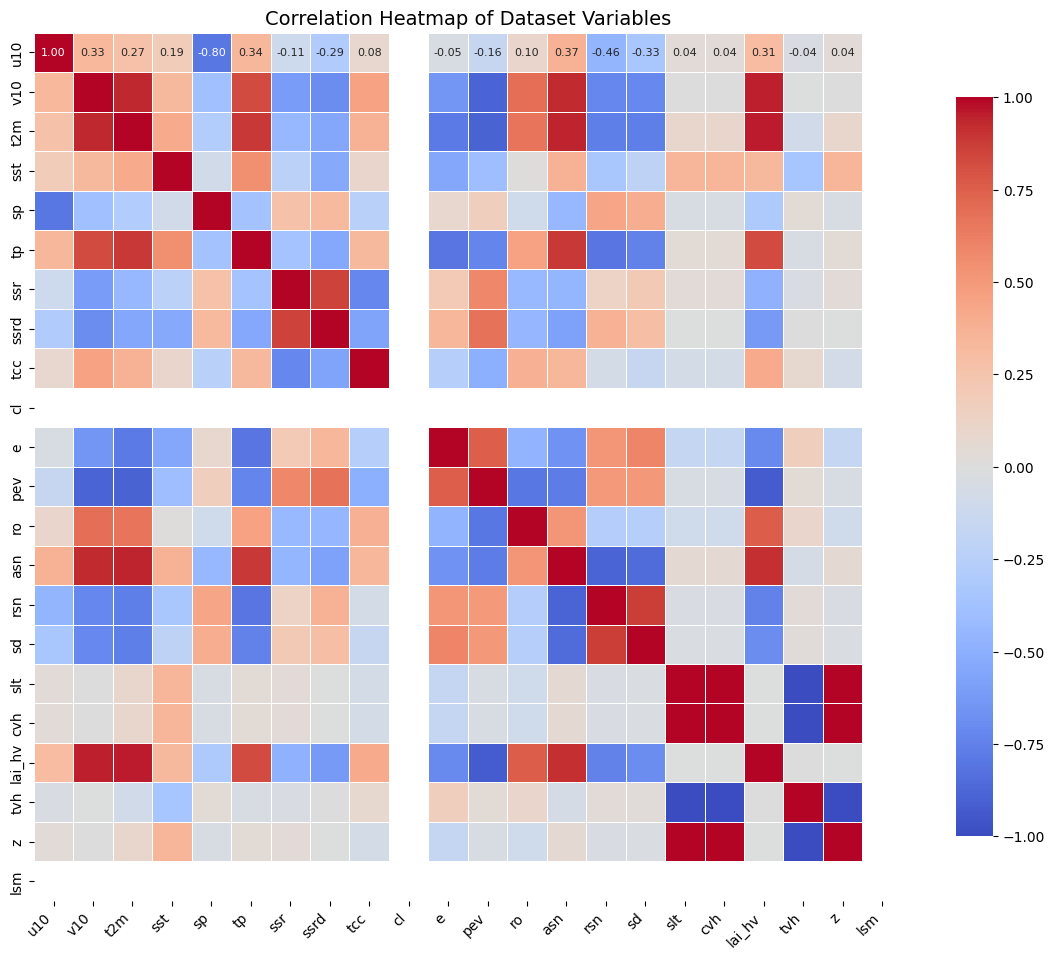

In [37]:
plot_variable_correlation_heatmap(ds)

In [1]:
# import zipfile
# import os

# def unzip_file(zip_path: str, extract_to: str = None) -> None:
#     """
#     Unzips the specified zip file to the given directory, creating the directory if it does not exist.
    
#     Args:
#         zip_path (str): The path to the zip file.
#         extract_to (str, optional): The directory to extract the files to. 
#                                     If not provided, extracts to the same directory as the zip file.
    
#     Raises:
#         FileNotFoundError: If the specified zip file does not exist.
#         zipfile.BadZipFile: If the file is not a valid zip file.
#     """
#     if not os.path.isfile(zip_path):
#         raise FileNotFoundError(f"The file {zip_path} does not exist.")
    
#     # If no extract path is specified, use the directory containing the zip file
#     if extract_to is None:
#         extract_to = os.path.dirname(zip_path)
    
#     # Create the extraction directory if it doesn't exist
#     os.makedirs(extract_to, exist_ok=True)
    
#     # Unzip the file
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to)
#     print(f"Unzipped {zip_path} to {extract_to}")

# # Example usage
# zip_path = "/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/01_raw/1f23f2661ea1cb7cdef5f1c60b436ae9.zip"
# extract_to = "/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/01_raw/extracted_files"
# unzip_file(zip_path, extract_to)


Unzipped /Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/01_raw/1f23f2661ea1cb7cdef5f1c60b436ae9.zip to /Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/01_raw/extracted_files


In [29]:
# import zipfile
# import os
# import xarray as xr
# import glob

# def load_combined_nc_files(directory_path: str, chunks=None, concat_dim=None, combine='by_coords') -> xr.Dataset:
#     """
#     Loads and combines all .nc files in the specified directory into a single xarray.Dataset.
    
#     Args:
#         directory_path (str): The path to the directory containing .nc files.
#         chunks (dict or 'auto', optional): Chunk sizes along each dimension for Dask. By default, no chunking is applied.
#         concat_dim (str or None, optional): Dimension to concatenate along. Only required if combine='nested'.
#         combine (str, optional): Combining method, either 'by_coords' or 'nested'. Default is 'by_coords'.
        
#     Returns:
#         xarray.Dataset: The combined dataset from all .nc files.
#     """
#     nc_files_pattern = os.path.join(directory_path, "*.nc")
#     dataset = xr.open_mfdataset(
#         nc_files_pattern,
#         chunks=chunks,
#         concat_dim=concat_dim,
#         combine=combine
#     )
#     print(f"Loaded and combined .nc files from {directory_path} into a single dataset")
#     return dataset

# # Load and combine all .nc files from the extracted directory
# sm_ds = load_combined_nc_files(extract_to, chunks='auto')


Loaded and combined .nc files from /Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/01_raw/extracted_files into a single dataset


In [30]:
# sm_ds

<xarray.Dataset> Size: 11GB
Dimensions:     (lat: 720, lon: 1440, time: 530)
Coordinates:
  * lat         (lat) float32 3kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon         (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time        (time) datetime64[ns] 4kB 1978-11-01 1978-12-01 ... 2022-12-01
Data variables:
    sm          (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sensor      (time, lat, lon) float64 4GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    freqbandID  (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs        (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    title:                        C3S Satellite Surface Soil Moisture COMBINE...
    institution:                  TU Wien (AUT); VanderSat B.V. (NL)
    contact:                      cci_sm_contact@eodc.eu
    source:                       WARP 5.5R1.1/AMI-WS/ERS12 Level 2 Soil Mois...
    platform:                     Nimbus 7, DMSP, TRMM, AQUA, Coriolis, GCOM-...
    processing_level:             Quality-controlled, super-collocated (L3S) ...
    ...                           ...
    id:                           C3S-SOILMOISTURE-L3S-SSMV-COMBINED-MONTHLY-...
    history:                      2023-06-29T14:21:20.489002 mean calculated
    date_created:                 2023-06-29T14:21:20Z
    time_coverage_duration:       P1M
    time_coverage_start:          1978-10-31T12:00:00Z
    time_coverage_end:            1978-11-30T12:00:00Z

In [31]:
# # INTO 3.data_preprocessing.ipynb 

# # Renaming coordinates in the xarray.Dataset
# sm_ds = sm_ds.rename({
#     "time": "date",
#     "lat": "latitude",
#     "lon": "longitude"
# })

In [32]:
# sm_ds = sm_ds.compute()

In [39]:
# variable = 'sm'

# fig = visualize_variable_on_map(
#     dataset=sm_ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=15,
#     color_scale = 'Bluered_r'
# )
# fig.show()